In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scikit_posthocs as sp
import os
from kneed import KneeLocator
from decimal import Decimal
from collections import Counter
from scipy import stats


In [2]:
geneID_file = '../data/all_human_genes_ID.txt'
enstEnsg_file = '../data/human_ENST_ENSG_symbol.tsv'
dctEnstEnsg_file = '../data/dct_enstToensg.pkl'
data_file = '../data/binary_pc_interpretation.tsv'
dataPval_file = '../data/binary_pc_interpret_pvalues_abs.txt'
cosmic_file = '../data/COSMIC_censusGenes.tsv'
dctTumor_file = '../data/dct_tumor.pkl'
dctTissue_file = '../data/dct_tissues.pkl'
dctDataset_file = '../data/dct_dataset.pkl'
conservationPos_file = '../data/conservation_high_pos.tsv'
conservationNeg_file = '../data/conservation_high_neg.tsv'
conservationNeutral_file = '../data/conservation_neutral.tsv'
loeuf_file = '../data/gnomad.v2.1.1.lof_metrics.by_gene.tsv'
highPos_file = '../data/genes_high_pos.txt'
highNeg_file = '../data/genes_high_neg.txt'
neutral_file = '../data/genes_neutral.txt'
highPos_fasta = '../data/genes_high_pos.fa'
highNeg_fasta = '../data/genes_high_neg.fa'
neutral_fasta = '../data/genes_neutral.fa'
lsvHigh_file = '../data/genes_lsv_high.txt'
lsvNeutral_file = '../data/genes_lsv_neutral.txt'
mutation_file = '../data/MUTATIONS_summary.tsv'
structuralVariant_file = '../data/STRUCTURAL_VARIANT_summary.tsv'

## Reference dictionaries and dataframes

In [3]:
df_ref = pd.read_csv(geneID_file, sep='\t')

dct_ref = dict(zip(df_ref['Gene stable ID'], df_ref['Gene name']))

dct_refENGS = dict(zip(df_ref['Gene name'], df_ref['Gene stable ID']))

ensg_to_enst = pd.read_csv(enstEnsg_file, sep='\t', index_col=0)
ensg_to_enst = ensg_to_enst.groupby(ensg_to_enst.index).agg(list)
ensg_to_enst = dict(zip(ensg_to_enst.index, ensg_to_enst['ensembl_transcript_id']))

enst_to_ensg = pd.read_csv(enstEnsg_file, sep='\t', index_col=1)
enst_to_ensg = dict(zip(enst_to_ensg.index, enst_to_ensg['ensembl_gene_id']))

df_pc = pd.read_csv(data_file, sep='\t', index_col=0)
## change gene ID from ensembleID to gene symbol
df_pc.columns = df_pc.columns.map(dct_ref)


In [4]:
def write_pval(pval, x, y, threshold):
    if pval < threshold:
        plt.text(x, y, '%.2e' % Decimal(pval), fontsize=font_size, ha='center', va='bottom')
    else:
        plt.text(x, y, '%.3f' % pval, fontsize=font_size, ha='center', va='bottom')


## distribution of tissues and datasets

In [5]:
## make dictionaries to group samples by tumor type, tissue type or dataset when necessary
with open(dctTumor_file, 'rb') as dct_tumor:
    dct_tumor = pickle.load(dct_tumor)
    
with open(dctTissue_file, 'rb') as dct_tissues:
    dct_tissues = pickle.load(dct_tissues)
    
with open(dctDataset_file, 'rb') as dct_datasetSamples:
    dct_datasetSamples = pickle.load(dct_datasetSamples)
    
    
## fetching COSMIC genes info
df_cosmic = pd.read_csv(cosmic_file,
                       sep='\t', index_col='Gene Symbol')


cosmic_genes = [x for x in df_cosmic.index.tolist() if x in df_pc.columns]


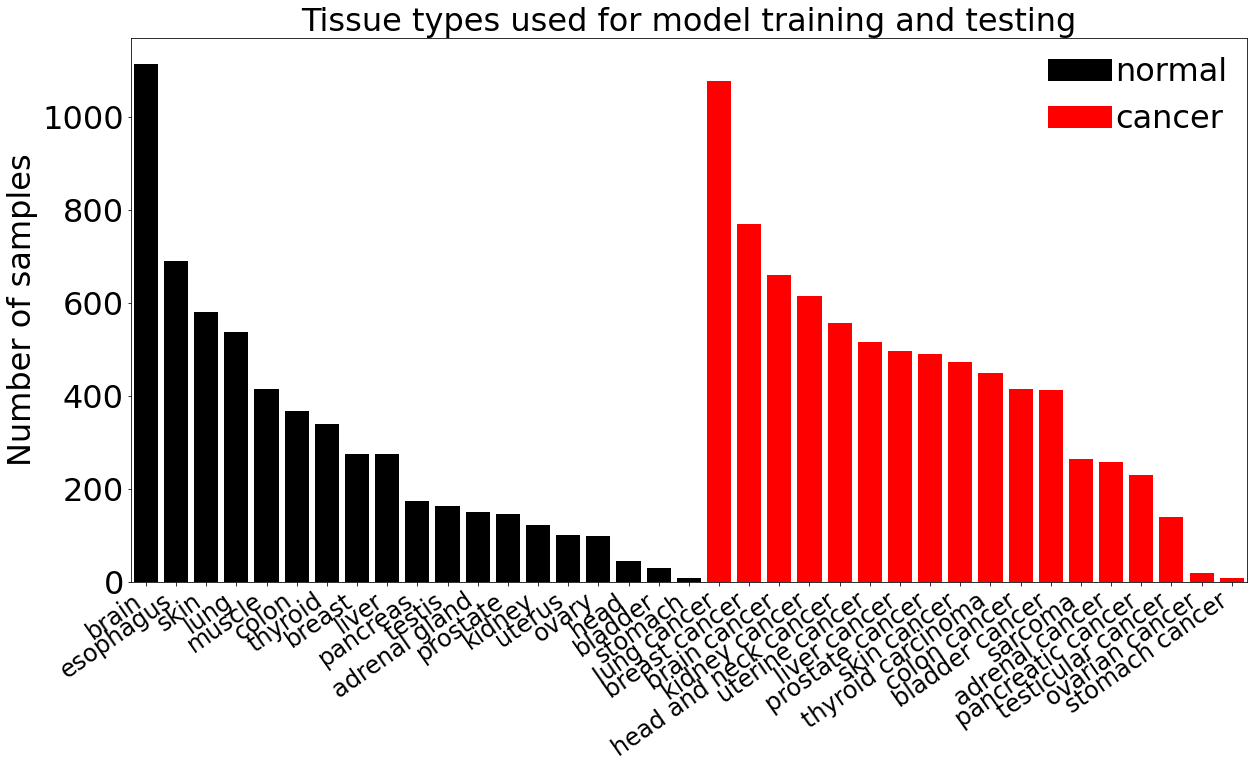

In [6]:
## plot distribution of tissues in datasets used to train and test the model

# df_dataset = pd.DataFrame(index=)
tissues = sorted(Counter(dct_tissues.values()), key=Counter(dct_tissues.values()).get, reverse=True)

## rank tissues with normal first, then cancer
tissues_sorted = []
for tissue in tissues:
    if 'healthy' in tissue:
        tissues_sorted.append(tissue)
for tissue in tissues:
    if 'tumor' in tissue:
        tissues_sorted.append(tissue)

        
fig,ax = plt.subplots(figsize=(20,10))


font_size=32

plt.title('Tissue types used for model training and testing', fontsize=font_size)

for ii,tissue in enumerate(tissues_sorted):
    
    if 'healthy' in tissue:
        plt.bar(ii, len([x for x in dct_tissues if dct_tissues[x] == tissue]), color='black', label='normal')
    elif 'tumor' in tissue:
        plt.bar(ii, len([x for x in dct_tissues if dct_tissues[x] == tissue]), color='red', label='cancer')
    

## dealing with repeated legend labels from for loop
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=font_size, markerscale=6, handletextpad=0.1,
           frameon=False, loc='upper right', borderpad=0.1)

plt.xticks(range(len(tissues_sorted)), [' '.join(x.split('_')[:-1]) for x in tissues_sorted],
           rotation=35, ha='right', va='top', fontsize=font_size*0.75)
plt.yticks(fontsize=font_size)
plt.ylabel('Number of samples', fontsize=font_size)
plt.xlim(-0.5, len(tissues_sorted)-0.5)

plt.savefig('../figures/distribution_tissues.pdf', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

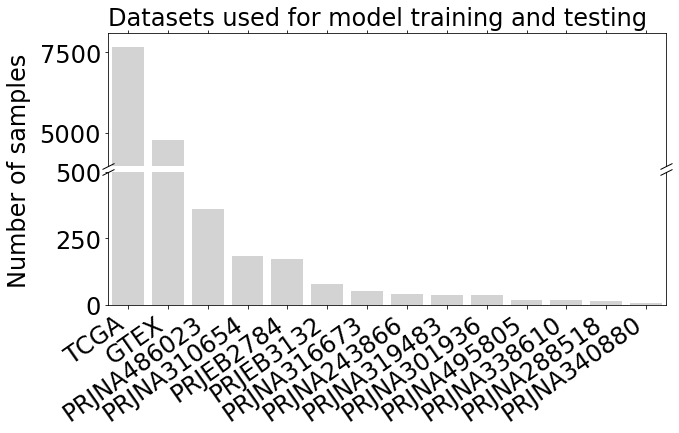

In [7]:
## plot distribution of datasets used to train and test the model

datasets = sorted(Counter(dct_datasetSamples.values()), key=Counter(dct_datasetSamples.values()).get, reverse=True)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,5))

font_size=24

fig.text(0.5, 0.92, 'Datasets used for model training and testing',
         va="center", ha='center', fontsize=font_size) ## manually add title


fig.subplots_adjust(hspace=0.05)  # adjust space between axes

plt.xticks(range(len(datasets)), [x.upper() for x in datasets], rotation=35, ha='right', va='top', fontsize=font_size)



for ii,dataset in enumerate(datasets):
    
    ax1.bar(ii, len([x for x in dct_datasetSamples if dct_datasetSamples[x] == dataset]), color='lightgrey')
    ax2.bar(ii, len([x for x in dct_datasetSamples if dct_datasetSamples[x] == dataset]), color='lightgrey')
    
ax1.set_ylim(4000, 8100)  # outliers only
ax2.set_ylim(0, 500)  # most of the data

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
ax.tick_params(axis='x', length=0)

fig.text(-0.015, 0.5, 'Number of samples', va="center", rotation="vertical", fontsize=font_size) ## manually add ylabel


d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.tick_params(axis='both', labelsize=font_size)
ax2.tick_params(axis='y', labelsize=font_size)

plt.xlim(-0.5, len(datasets)-0.5)

plt.savefig('../figures/distribution_datasets.pdf', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

## selection of high-attribution features

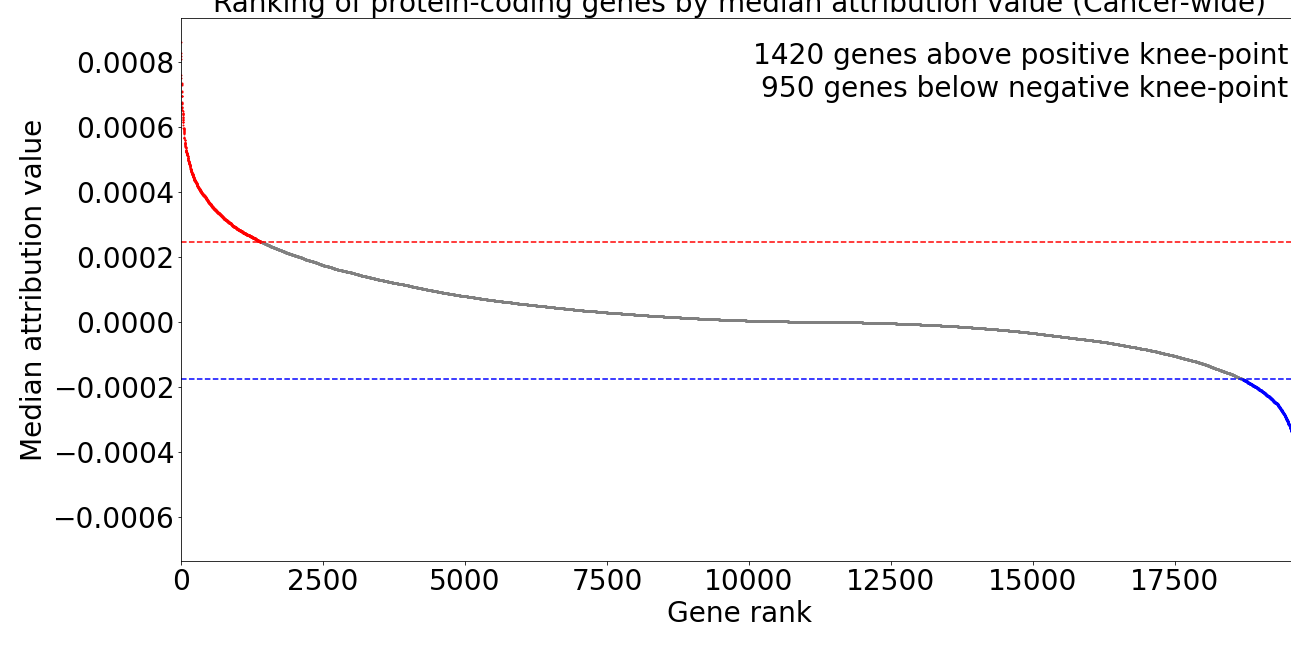

In [10]:
## plot distribution of attribution values showing median to find kneepoints


## function to smoothen curve made up of attribution values

def smooth(y, box_pts):
        y_smooth = np.convolve(y, np.ones((box_pts,)) / float(box_pts), mode='valid')
        return y_smooth


## breaking down plot between positive and negative attributions and finding the two knee points

attr_median = pd.read_csv(dataPval_file,
                        sep='\t', index_col=0)


attr_median.index = attr_median.index.map(dct_ref)

attr_median['pval'] = -np.log10(attr_median['Corrected P-values (FDR <= 1%)'])

## sort df_attr from highest to lowest attribution value
attr_median = attr_median.sort_values(by='Median-Attributions', ascending=False)

attr_median_pos = attr_median[attr_median['Median-Attributions'] >= 0]
attr_median_neg = attr_median[attr_median['Median-Attributions'] < 0]


x = [x for x in range(len(attr_median.index))]
xpos = [x for x in range(len(attr_median_pos))]
xneg = [x for x in range(len(attr_median_neg))]
    
    
y = smooth(attr_median_pos['Median-Attributions'], 25)
smooth_x = np.arange(len(y))

kneedle = KneeLocator(smooth_x, y, S=1.0, curve="convex", direction="decreasing")

cutoff_pos = y[kneedle.knee]

y = smooth(attr_median_neg['Median-Attributions'], 25)
smooth_x = np.arange(len(y))

kneedle = KneeLocator(smooth_x, y, S=1.0, curve="concave", direction="decreasing")

cutoff_neg = y[kneedle.knee]


## plot distribution curve for attribution values and show knee points
red1 = [x for x in attr_median['Median-Attributions'] if x > cutoff_pos]
black = [x for x in attr_median['Median-Attributions'] if x <= cutoff_pos and x >= cutoff_neg]
red2 = [x for x in attr_median['Median-Attributions'] if x < cutoff_neg]

fig,ax = plt.subplots(figsize=(20,10))

font_size = 28

plt.title('Ranking of protein-coding genes by median attribution value (Cancer-wide)', fontsize=font_size)

plt.scatter([x for x in range(len(red1))], red1, s=1, color='red', rasterized=True)
plt.scatter([x+len(red1) for x in range(len(black))], black, s=1, color='grey', rasterized=True)
plt.scatter([x+len(red1)+len(black) for x in range(len(red2))], red2, s=1, color='blue', rasterized=True)

plt.xticks(fontsize = font_size)
plt.yticks(fontsize = font_size)
plt.xlabel('Gene rank', fontsize=font_size)
plt.ylabel('Median attribution value', fontsize=font_size)
plt.xlim(min(x), max(x))
plt.axhline(cutoff_pos, linestyle='--', color='red')
plt.axhline(cutoff_neg, linestyle='--', color='blue')
         
plt.text(max(x), max(attr_median['Median-Attributions']), str(len(red1)) + ' genes above positive knee-point \n' +\
                                    str(len(red2)) + ' genes below negative knee-point \n',# +\
        fontsize=font_size,
        ha='right', va='top')

plt.savefig('../figures/attribution_distribution_PC_median.pdf', dpi=600, bbox_inches='tight')
plt.show()
plt.close()


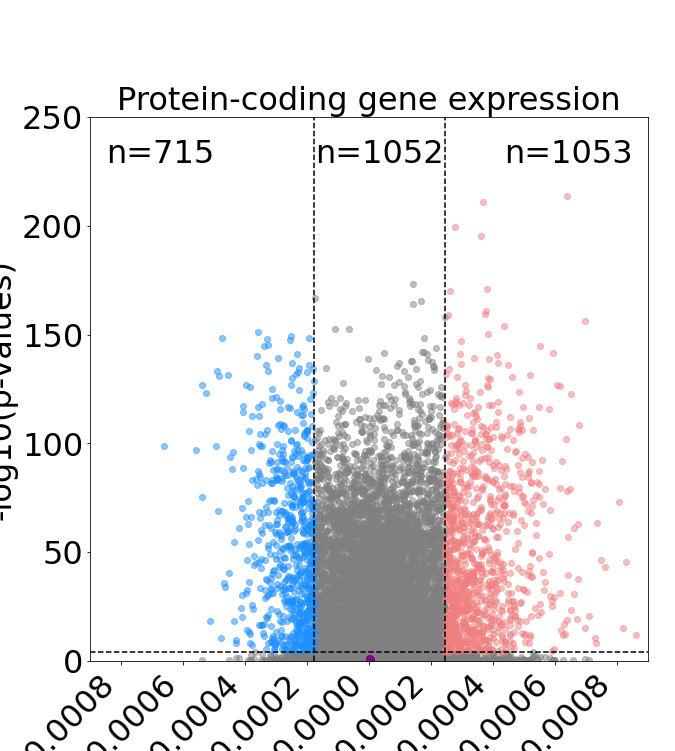

In [15]:
## make volcano plots using p-values associated with attribution values

pval_cutoff = 4 ## corresponds to p<0.0001

df_volcano_significant = attr_median[attr_median['pval'] > pval_cutoff]

df_volcano_pos = df_volcano_significant[df_volcano_significant['Median-Attributions'] > cutoff_pos]
df_volcano_neg = df_volcano_significant[df_volcano_significant['Median-Attributions'] < cutoff_neg]


## list genes with significant high positive or negative attribution values for GO and other downstream analyses
genes_high_pos = df_volcano_pos.index
genes_high_neg = df_volcano_neg.index

## first method of making neutral set by selecting similar number of neutral genes as the size of the positively or negatively highPos gene population at the center of the distribution
num_neutral = max([len(genes_high_pos), len(genes_high_neg)]) ## number of features included in neutral set is equal to set that has most features between high-negative and high-positive
attr_median_neutral = attr_median[attr_median['pval'] < 1.3]
neutral_position = int(len(attr_median_neutral)/2)
genes_neutral = attr_median_neutral.index.values[(neutral_position - int(num_neutral/2)):(neutral_position + int(num_neutral/2))]
df_volcano_neutral = attr_median[attr_median.index.isin(genes_neutral)]

df_volcano_nonsignificant = attr_median[~attr_median.index.isin(df_volcano_pos.index.tolist() + df_volcano_neg.index.tolist())]


fig,ax = plt.subplots(figsize=(10,10))

font_size=32

plt.title('Protein-coding gene expression', fontsize=font_size)

plt.plot(df_volcano_nonsignificant['Median-Attributions'], df_volcano_nonsignificant['pval'], 'o',
         color='grey', alpha=0.5, rasterized=True)
plt.plot(df_volcano_pos['Median-Attributions'], df_volcano_pos['pval'], 'o',
         color='lightcoral', alpha=0.5, rasterized=True)
plt.plot(df_volcano_neg['Median-Attributions'], df_volcano_neg['pval'], 'o',
         color='dodgerblue', alpha=0.5, rasterized=True)
plt.plot(df_volcano_neutral['Median-Attributions'], df_volcano_neutral['pval'], 'o',
         color='purple', alpha=0.5, rasterized=True)


plt.text(-0.00085, 240, 'n=' + str(len(genes_high_neg)), ha='left', va='top', fontsize=font_size)
plt.text(0.00085, 240, 'n=' + str(len(genes_high_pos)), ha='right', va='top', fontsize=font_size)
plt.text((cutoff_pos + cutoff_neg)/2, 240, 'n=' + str(len(genes_neutral)), ha='center', va='top', fontsize=font_size)

plt.axvline(cutoff_pos, linestyle='--', color='black')
plt.axvline(cutoff_neg, linestyle='--', color='black')
plt.axhline(4, linestyle='--', color='black')

plt.xticks(fontsize=font_size, rotation=45, ha='right', va='top')
plt.yticks(fontsize=font_size)

plt.xlabel('Attribution values', fontsize=font_size)
plt.ylabel('-log10(p-values)', fontsize=font_size)

plt.xlim(-0.0009, 0.0009)
plt.ylim(0, 250)

plt.savefig('../figures/volcano_attribution_PC_median.pdf', dpi=600, bbox_inches='tight')
plt.show()
plt.close()


top genes is the number of top genes per tissue to plot


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


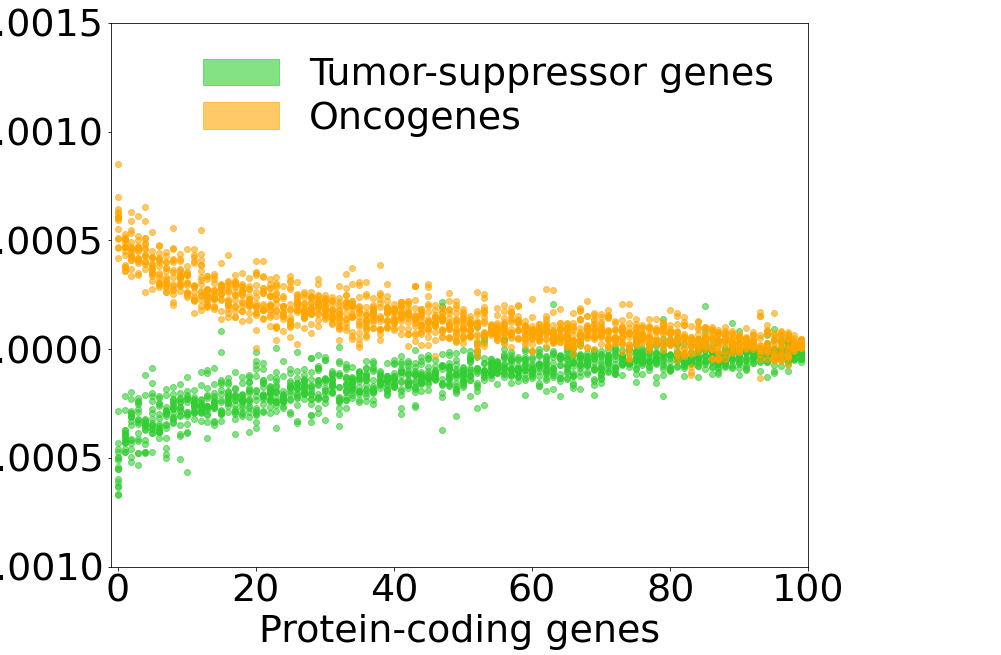

top genes is the number of top genes per tissue to plot


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


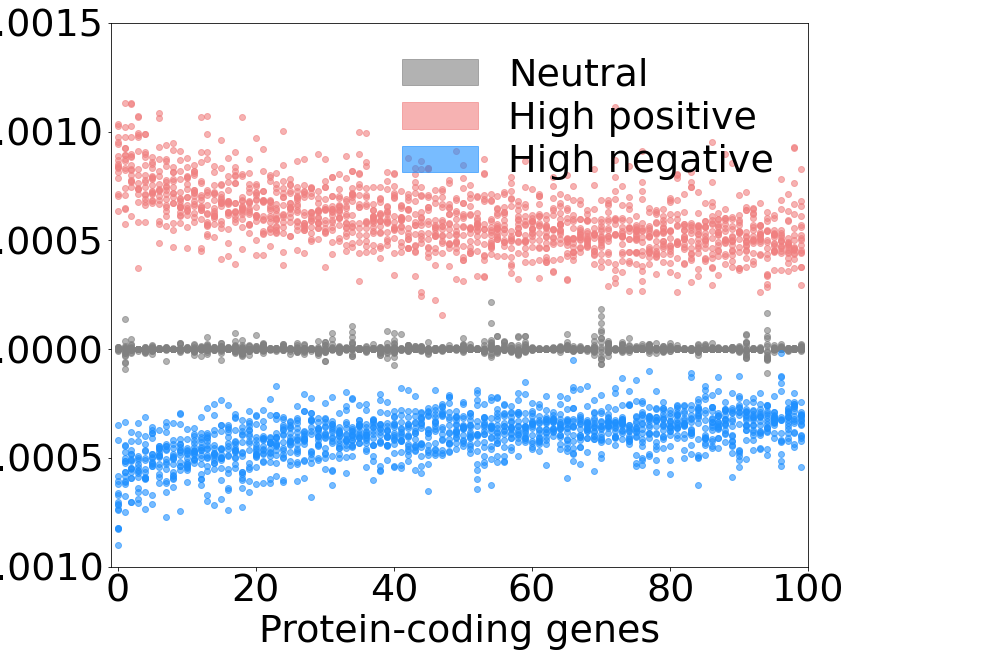

In [10]:
## Plot how attribution values of a set of genes look across cancer types

def plot_top_genes_perTissue(gene_list, groups, dct_tumor, df_pc, title, colors, save_as):
    print ('top genes is the number of top genes per tissue to plot')
    
    tumors = [x for x in set(dct_tumor.values()) if x not in ['stomach_cancer_tumor', 'ovarian_cancer_tumor']] ## remove stomach and ovarian cancer because we have low numbers
    
    
    tumor_samples = [x for x in df_pc.index if dct_tumor[x] in tumors]
    
    
    df = df_pc[df_pc.index.isin(tumor_samples)]
    
    
    fig,ax = plt.subplots(figsize=(12.5,10))
    
    
    font_size = 38
    
    starting_x = 0
    
    
    for ii,genes in enumerate(gene_list):
        
        genes = [gene for gene in genes if gene in df.columns]
        
        df_tmp = df[genes]
        
        for tumor_type in tumors:
            samples = [x for x in tumor_samples if dct_tumor[x] == tumor_type]
            median = df_tmp[df_tmp.index.isin(samples)].median(axis=0)
            df_tmp.loc['median_'+tumor_type] = median
            
        df_tmp = df_tmp[df_tmp.index.str.contains('median')]
        
        for iii,gene in enumerate(genes):
            x = [iii for x in range(len(df_tmp))]
            y = df_tmp[gene].tolist()
                 
#             plt.scatter(x, y, color = colors[ii], s=6)
            plt.plot(x, y, 'o', color = colors[ii], alpha=0.6, rasterized=True)
        
        starting_x += len(genes)
        
    plt.ylabel('Median attribution value\nper tumor type', fontsize=font_size)
    plt.xlabel('Protein-coding genes', fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.xlim(-1, 100)
    plt.ylim(-0.001, 0.0015)
    
    ## manual legend
    patches = []
    for ii,group in enumerate(groups):
        patch = mpatches.Patch(color=colors[ii], label=group, alpha=0.6)
        patches.append(patch)
        
    plt.legend(handles=patches, frameon=False, fontsize=font_size, labelspacing = 0.2)
    
    plt.savefig(save_as + '.pdf', dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()
    

    
## plotting median attribution values of TSGs and oncogenes from COSMIC for each cancer type

num_genes = 100

df_cosmic = pd.read_csv(cosmic_file,
                       sep='\t', index_col='Gene Symbol')

## remove genes related to blood cancers because we don't have anything blood in the datasets used to train
## and test the models
df_cosmic = df_cosmic[df_cosmic['Role in Cancer'].notna()]

TSG = df_cosmic[df_cosmic['Role in Cancer'].str.contains('TSG')]
TSG = TSG[~TSG['Role in Cancer'].str.contains('oncogene')]
TSG = TSG.index.tolist()

oncogene = df_cosmic[df_cosmic['Role in Cancer'].str.contains('oncogene')]
oncogene = oncogene[~oncogene['Role in Cancer'].str.contains('TSG')]
oncogene = oncogene.index.tolist()

## sort TSGs and oncogenes by median attribution value to plot top 100 TSGs with lowest and 100 oncogenes with highest attributions
TSG = [x for x in attr_median.index[::-1] if x in TSG][:num_genes]
oncogene = [x for x in attr_median.index if x in oncogene][:num_genes]


title = 'COSMIC genes'
groups = ['Tumor-suppressor genes', 'Oncogenes']
colors = ['limegreen', 'orange']
save_as = '../figures/attribution_PC_median_cosmic'

plot_top_genes_perTissue([TSG, oncogene], groups, dct_tumor,
                         df_pc, title, colors, save_as)



## plotting median attribution values of top XX genes for each cancer type

num_genes = 100


genes_highPos = pd.read_csv(highPos_file,
                            header=None)[0].tolist()
genes_highPos = [x for x in genes_highPos if x not in oncogene and x not in TSG]
genes_highPos = genes_highPos[:num_genes]


genes_highNeg = pd.read_csv(highNeg_file,
                            header=None)[0].tolist()    
genes_highNeg = [x for x in genes_highNeg if x not in oncogene and x not in TSG]
genes_highNeg = genes_highNeg[:num_genes]


genes_neutral = pd.read_csv(neutral_file,
                            header=None)[0].tolist()
genes_neutral = [x for x in genes_neutral if x not in oncogene and x not in TSG]
genes_neutral = genes_neutral[int(len(genes_neutral)/2)-int(num_genes/2): int(len(genes_neutral)/2)-int(num_genes/2)+num_genes]


title = 'Top ' + str(num_genes*2) + ' protein-coding genes'
groups = ['Neutral', 'High positive', 'High negative']
colors = ['grey', 'lightcoral', 'dodgerblue']
save_as = '../figures/attribution_PC_median_tumors'

plot_top_genes_perTissue([genes_neutral, genes_highPos, genes_highNeg], groups, dct_tumor,
                         df_pc, title, colors, save_as)

ready to plot conservation scores


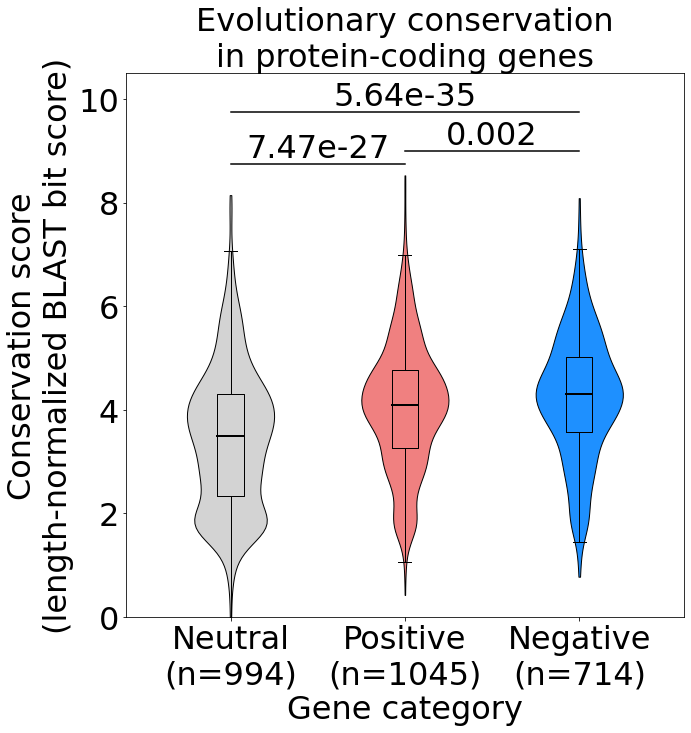

In [11]:
## Assess evolutionary conservation

def assess_conservation(conservation_file, dct_enstToensg):
    
    header = ['query acc', 'query length', 'subject acc', 'subject length', 'bit score', 'score',
          'alignment length', '% identity', 'subject tax id']
    
    df_conservation = pd.read_csv(conservation_file,
                                          header=None, sep='\t', comment='#')

    df_conservation.columns = header

    df_conservation['query acc'] = df_conservation['query acc'].map(dct_enstToensg)

    genes = set(df_conservation['query acc'].tolist())

    dct_conservation = {}
    for ii,gene in enumerate(genes):
        ## subset dataframe to one gene
        df_tmp = df_conservation[df_conservation['query acc'] == gene]
        ## remove human taxid because normalized score (see 4 lines below) will always be 1.847
        df_tmp = df_tmp[df_tmp['subject tax id'] != 9606]
        ## order dataframe by descending bit score values
        df_tmp = df_tmp.sort_values(by='bit score', axis=0, ascending=False)
        ## select match with greatest bit score for each taxid
        df_tmp.index = df_tmp['subject tax id']
        df_tmp = df_tmp[~df_tmp.index.duplicated(keep='first')]
        ## add normalized score corresponding to bit score normalized by query length
        df_tmp['normalized score'] = df_tmp['bit score'] / df_tmp['query length']
        
        normalized_score = np.sum(df_tmp['normalized score'])
        
        try:
            dct_conservation[df_tmp.iloc[0]['query acc']] = normalized_score
        except IndexError:
            ## this exception catches genes with no match in species other than Homo sapiens and assigns a score of 0
            dct_conservation[gene] = 0
            
    return dct_conservation
    
    
with open(dctEnstEnsg_file, 'rb') as dct_enstToensg:
    dct_enstToensg = pickle.load(dct_enstToensg)
    
    
##  genes
dct_conservation_highPos = assess_conservation(conservationPos_file, dct_enstToensg)

## highNeg genes
dct_conservation_highNeg = assess_conservation(conservationNeg_file, dct_enstToensg)

## neutral genes
dct_conservation_neutral = assess_conservation(conservationNeutral_file, dct_enstToensg)


print ('ready to plot conservation scores')


## plot conservation scores

groups = ['Neutral\n(n=' + str(len(dct_conservation_neutral)) + ')',
          'Positive\n(n=' + str(len(dct_conservation_highPos)) + ')',
          'Negative\n(n=' + str(len(dct_conservation_highNeg)) + ')']

dcts = [dct_conservation_neutral, dct_conservation_highPos, dct_conservation_highNeg]

fig,ax = plt.subplots(figsize=(10,10))

font_size = 32

plt.title('Evolutionary conservation\nin protein-coding genes', fontsize=font_size)

tstat_neutralhighPos, pval_neutralhighPos = stats.ttest_ind([x for x in dct_conservation_neutral.values()],
                                                              [x for x in dct_conservation_highPos.values()])

tstat_neutralhighNeg, pval_neutralhighNeg = stats.ttest_ind([x for x in dct_conservation_neutral.values()],
                                                              [x for x in dct_conservation_highNeg.values()])

tstat_highPoshighNeg, pval_highPoshighNeg = stats.ttest_ind([x for x in dct_conservation_highPos.values()],
                                                              [x for x in dct_conservation_highNeg.values()])

for ii,group in enumerate(groups):
    
    y = dcts[ii].values()
    x = np.random.normal(ii, 0.15, size=len(y))

    vp = plt.violinplot(
            y, positions = [ii],
        showmeans=False, showmedians=False,
            showextrema=False)

    for pc in vp['bodies']:
        pc.set_facecolor(['lightgrey', 'lightcoral', 'dodgerblue'][ii])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        
    box1 = plt.boxplot(y, positions = [ii], showfliers=False)
    plt.setp(box1['medians'], color='black', linewidth=2)
    
    
plt.plot([0,1], [8.75,8.75], color='black')
plt.plot([1,2], [9,9], color='black')
plt.plot([0,2], [9.75,9.75], color='black')

        
write_pval(pval_neutralhighPos, 0.5, 8.75, 0.001)
write_pval(pval_highPoshighNeg, 1.5, 9, 0.001)
write_pval(pval_neutralhighNeg, 1, 9.75, 0.001)

plt.xticks(range(len(groups)), groups, fontsize=font_size)
plt.xlabel('Gene category', fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.ylabel('Conservation score\n(length-normalized BLAST bit score)', fontsize=font_size)
plt.xlim(-0.6, 2.6)
plt.ylim(0,10.5)

plt.savefig('../figures/conservation_score_PC.pdf',
            dpi=600, bbox_inches='tight')
plt.show()
plt.close()

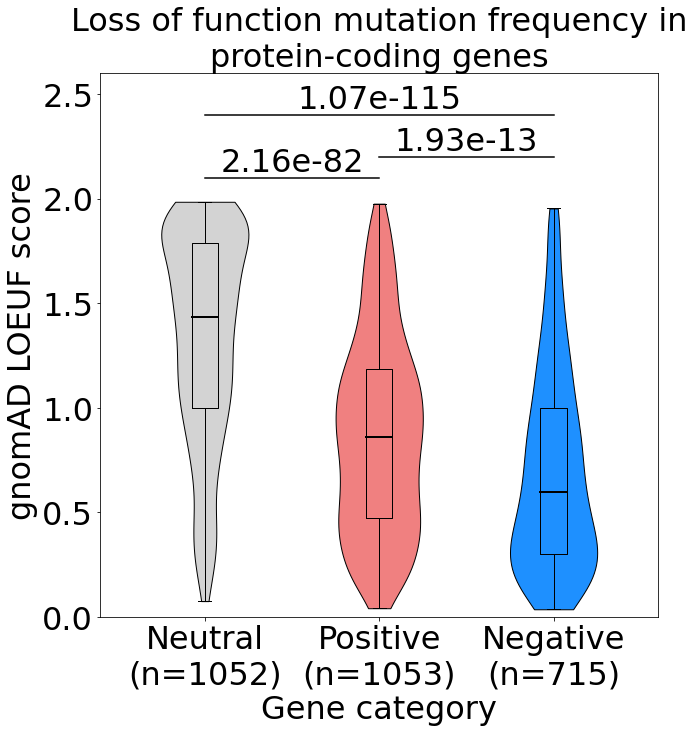

In [12]:
## Plot LOEUF scores (gnomAD) for highPos, highNeg and neutral genes

## fetch LOEUF score

df_loeuf = pd.read_csv(loeuf_file,
                      sep='\t', index_col='transcript')

dct_noVersion_enstToensg = {}
for key in dct_enstToensg:
    dct_noVersion_enstToensg[key.split('.')[0]] = dct_enstToensg[key]
    
df_loeuf.index = df_loeuf.index.map(dct_noVersion_enstToensg)

## only keep transcript with highest LOEUF score gene a gene has more than one transcript listed in gnomAD
df_loeuf = df_loeuf[~df_loeuf.index.duplicated(keep='first')]

## remove genes for which no LOEUF score is defined (nan)
df_loeuf = df_loeuf[df_loeuf['oe_lof_upper'].notna()]


genes_highPos = pd.read_csv(highPos_file,
                            header=None)[0].tolist()
genes_highNeg = pd.read_csv(highNeg_file,
                            header=None)[0].tolist()
genes_neutral = pd.read_csv(neutral_file,
                            header=None)[0].tolist()

groups = ['Neutral\n(n=' + str(len(genes_neutral)) + ')',
          'Positive\n(n=' + str(len(genes_highPos)) + ')',
          'Negative\n(n=' + str(len(genes_highNeg)) + ')']

dct_loeuf_neutral = {}
dct_loeuf_highPos = {}
dct_loeuf_highNeg = {}

for ii,gene in enumerate(genes_neutral):
    try:
        dct_loeuf_neutral[gene] = df_loeuf['oe_lof_upper'][gene]
    except KeyError:
        continue
    
for gene in genes_highPos:
    try:
        dct_loeuf_highPos[gene] = df_loeuf['oe_lof_upper'][gene]
    except KeyError:
        continue
    
for gene in genes_highNeg:
    try:
        dct_loeuf_highNeg[gene] = df_loeuf['oe_lof_upper'][gene]
    except KeyError:
        continue
    
dcts = [dct_loeuf_neutral, dct_loeuf_highPos, dct_loeuf_highNeg]


fig,ax = plt.subplots(figsize=(10,10))

font_size = 32

plt.title('Loss of function mutation frequency in\nprotein-coding genes', fontsize=font_size)

tstat_neutralhighPos, pval_neutralhighPos = stats.ttest_ind([x for x in dct_loeuf_neutral.values()],
                                                              [x for x in dct_loeuf_highPos.values()])

tstat_neutralhighNeg, pval_neutralhighNeg = stats.ttest_ind([x for x in dct_loeuf_neutral.values()],
                                                              [x for x in dct_loeuf_highNeg.values()])

tstat_highPoshighNeg, pval_highPoshighNeg = stats.ttest_ind([x for x in dct_loeuf_highPos.values()],
                                                              [x for x in dct_loeuf_highNeg.values()])

for ii,group in enumerate(groups):
    
    y = dcts[ii].values()
    x = np.random.normal(ii, 0.15, size=len(y))
#     plt.scatter(x, y, color = ['grey', 'lightcoral', 'dodgerblue'][ii], alpha = 0.5)
    vp = plt.violinplot(
            y, positions = [ii],
        showmeans=False, showmedians=False,
            showextrema=False)

    for pc in vp['bodies']:
        pc.set_facecolor(['lightgrey', 'lightcoral', 'dodgerblue'][ii])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    box1 = plt.boxplot(y, positions = [ii], showfliers=False)
    plt.setp(box1['medians'], color='black', linewidth=2)
#     plt.text(ii, 0, 'n=' + str(len(y)), fontsize = font_size/1.5, ha='center', va='bottom')
    
    
plt.plot([0,1], [2.1,2.1], color='black')
plt.plot([1,2], [2.2,2.2], color='black')
plt.plot([0,2], [2.4,2.4], color='black')

write_pval(pval_neutralhighPos, 0.5, 2.1, 0.001)
write_pval(pval_highPoshighNeg, 1.5, 2.2, 0.001)
write_pval(pval_neutralhighNeg, 1, 2.4, 0.001)

plt.xticks(range(len(groups)), groups, fontsize=font_size)
plt.xlabel('Gene category', fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.ylabel('gnomAD LOEUF score', fontsize=font_size)
plt.xlim(-0.6, 2.6)
plt.ylim(0, 2.6)

plt.savefig('../figures/loeuf_score_PC.pdf',
            dpi=600, bbox_inches='tight')
plt.show()
plt.close()



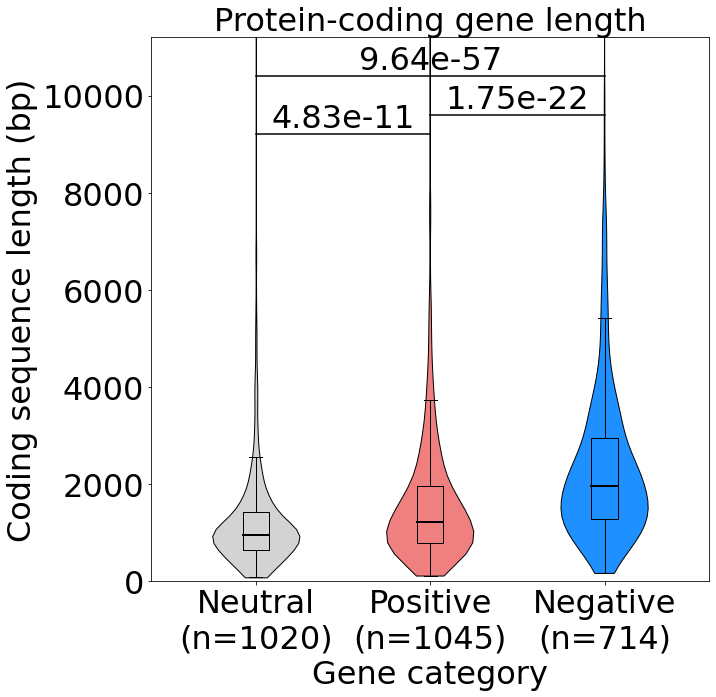

In [13]:
## Plot gene lengths

def make_transcriptLength_dct(infile):
    
    dct_length = {}
    with open(infile, 'r') as infile:
        
        for ii,line in enumerate(infile):
            line = line.strip()
            
            if '>' in line:
                gene_id = line.split('gene_symbol:')[1].split(' ')[0]
                count = 0
                
            else:
                count += len(line)
                dct_length[gene_id] = count
                
    return dct_length
                
dct_length_highPos = make_transcriptLength_dct(highPos_fasta)
dct_length_highNeg = make_transcriptLength_dct(highNeg_fasta)
dct_length_neutral = make_transcriptLength_dct(neutral_fasta)
    
dcts_lengths = [dct_length_neutral, dct_length_highPos, dct_length_highNeg]


groups = ['Neutral\n(n=' + str(len(dct_length_neutral)) + ')',
          'Positive\n(n=' + str(len(dct_length_highPos)) + ')',
          'Negative\n(n=' + str(len(dct_length_highNeg)) + ')']

## plot lncRNA gene lengths
fig,ax = plt.subplots(figsize=(10,10))

font_size = 32

plt.title('Protein-coding gene length', fontsize = font_size)

tstat_neutralhighPos, pval_neutralhighPos = stats.ttest_ind([dct_length_neutral[x] for x in dct_length_neutral],
                                                              [dct_length_highPos[x] for x in dct_length_highPos])

tstat_neutralhighNeg, pval_neutralhighNeg = stats.ttest_ind([dct_length_neutral[x] for x in dct_length_neutral],
                                                              [dct_length_highNeg[x] for x in dct_length_highNeg])

tstat_highPoshighNeg, pval_highPoshighNeg = stats.ttest_ind([dct_length_highPos[x] for x in dct_length_highPos],
                                                              [dct_length_highNeg[x] for x in dct_length_highNeg])

for ii,group in enumerate(groups):
    
    y = [dcts_lengths[ii][x] for x in dcts_lengths[ii]]
    x = np.random.normal(ii, 0.15, size=len(y))

    
    vp = plt.violinplot(
            y, positions = [ii],
        showmeans=False, showmedians=False,
            showextrema=False)

    for pc in vp['bodies']:
        pc.set_facecolor(['lightgrey', 'lightcoral', 'dodgerblue'][ii])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        
    box1 = plt.boxplot(y, positions = [ii], showfliers=False)
    plt.setp(box1['medians'], color='black', linewidth=2)
    
    
plt.plot([0,1], [9200, 9200], color='black')
plt.plot([1,2], [9600, 9600], color='black')
plt.plot([0,2], [10400, 10400], color='black')

write_pval(pval_neutralhighPos, 0.5, 9200, 0.001)
write_pval(pval_highPoshighNeg, 1.5, 9600, 0.001)
write_pval(pval_neutralhighNeg, 1, 10400, 0.001)


plt.xticks(range(len(groups)), groups, fontsize=font_size)
plt.xlabel('Gene category', fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.ylabel('Coding sequence length (bp)', fontsize=font_size)
plt.xlim(-0.6, 2.6)
plt.ylim(0, 11200)

plt.savefig('../figures/transcriptLength_PC.pdf',
            dpi=600, bbox_inches='tight')
plt.show()
plt.close()

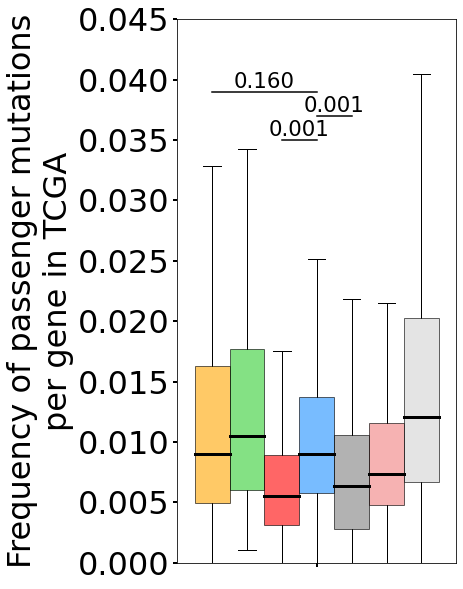

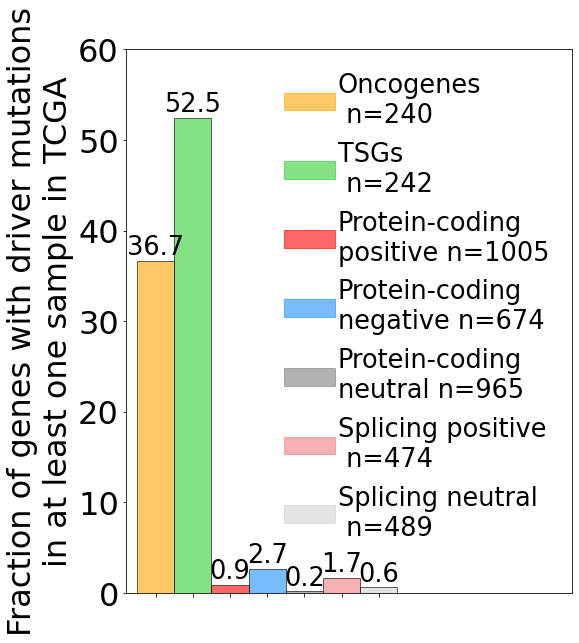

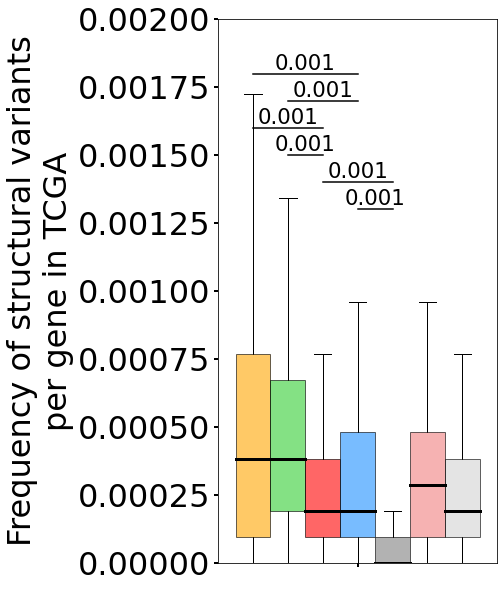

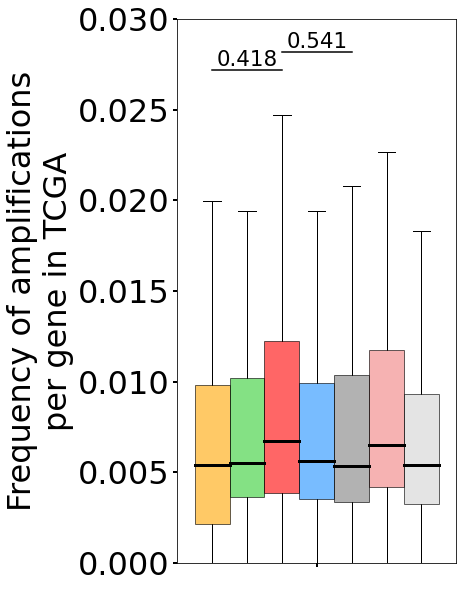

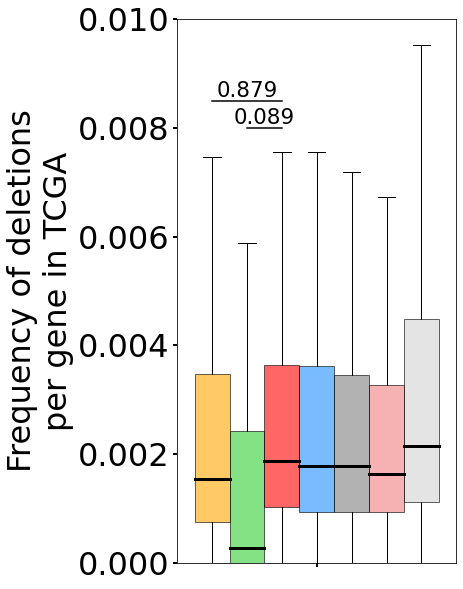

In [14]:
## plot variant frequency
def plot_variants(lst_df, groups, mutation_types, colors, x_labels, y_label, show_pval,
                  y_lim, ypval_factor, log_scale, ypval_spacing, figformat, save_as, **kwargs):
    
    legend_spacing = kwargs.get('legend_spacing', None)
    show_legend = kwargs.get('show_legend', None)
    y_pval_manual = kwargs.get('y_pval_manual', None)
    
    
    fig,ax = plt.subplots(figsize=figformat)

    font_size = 32
    
    
    subticks = [x/(len(lst_df) + 1) for x in range(len(lst_df))]
    
    x_pos = [x + np.mean(subticks) for x in range(len(mutation_types))]
    
    barwidth = 1/(len(lst_df)+1)
    
    
    for ii,mutation in enumerate(mutation_types):
        
        f_value, p_value = stats.f_oneway(*[x[mutation] for x in lst_df])
        
        pvals_posthoc = sp.posthoc_tukey([x[mutation] for x in lst_df])
        
        top_whiskers = []
        for iii,gene_type in enumerate(lst_df):
            
            bp = plt.boxplot(gene_type[mutation], positions = [subticks[iii]+ii],
                             showfliers=False, patch_artist=True, widths=barwidth)

            for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
                plt.setp(bp[item], color='black')

            plt.setp(bp["boxes"], facecolor=colors[iii], alpha=0.6)
            plt.setp(bp["medians"], linewidth=3)

            top_whiskers.append(max([item.get_ydata() for item in bp['whiskers']][1]))
        
        
        if y_pval_manual:
            y_pval = y_pval_manual
        else:
            y_pval = max(top_whiskers) + max(top_whiskers)*0.1 ## reset y position of lowest p-val
        
        
        if p_value < 0.05:
            if len(show_pval[0]) > 0:
                for pval_pairs in show_pval:
                    pval_posthoc = pvals_posthoc[pval_pairs[1]+1][pval_pairs[0]+1]

                    plt.plot([subticks[pval_pairs[0]]+ii, subticks[pval_pairs[1]]+ii], [y_pval, y_pval], color='black')
                    plt.text(np.mean([subticks[pval_pairs[0]]+ii, subticks[pval_pairs[1]]+ii]), y_pval,
                            ['%.2E' % Decimal(x) if x < 0.001 else '%.3f' % x for x in [pval_posthoc]][0],
                            ha='center', va='bottom', fontsize=font_size/1.5)
                    if y_pval < 0.05:
                        y_pval += ypval_spacing
                    else:
                        y_pval = (y_pval + y_pval*10)/ypval_factor
                            

    plt.xticks(x_pos, x_labels,
               fontsize=font_size, rotation=35, ha='right', va='top')
    plt.yticks(fontsize=font_size)
    plt.ylabel(y_label, fontsize=font_size)
    
    plt.xlim(x_pos[0]-0.5, x_pos[-1]+0.5)
    
    
    if log_scale is True:
        ax.set_yscale('symlog', linthresh=0.05)
        ax.set_yticks([0, 0.01, 0.05, 0.1, 0.5, 1, 5, 10])
        ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        subs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 2, 3, 4]
        ax.yaxis.set_minor_locator(ticker.LogLocator(subs=subs))
        
    ax.tick_params(which='both', length=4, width=2)
    
    plt.ylim(y_lim)
    
    ## manual legend
    tags = []
    for ii,group in enumerate(groups):
        tag = mpatches.Patch(color=colors[ii], label=groups[ii] + ' n=' + str(len(lst_df[ii].index)), alpha=0.6) 
        tags.append(tag)
        
    if show_legend is not False:
        if legend_spacing:
            plt.legend(handles=tags, frameon=False, fontsize=font_size/1.35, labelspacing=legend_spacing)

        else:
            plt.legend(handles=tags, frameon=False, fontsize=font_size/1.25)
    
    plt.savefig(save_as + '.pdf',
            dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()
    
    
## plot frequency of passenger variants in high-attribution genes in TCGA

genes_highPos = pd.read_csv(highPos_file,
                            header=None)[0].tolist()

genes_highNeg = pd.read_csv(highNeg_file,
                            header=None)[0].tolist()

genes_neutral = pd.read_csv(neutral_file,
                            header=None)[0].tolist()

genes_lsv_high = pd.read_csv(lsvHigh_file,
                            header=None)[0].tolist()
genes_lsv_high = [x.split(';')[0] for x in genes_lsv_high]

genes_lsv_neutral = pd.read_csv(lsvNeutral_file,
                            header=None)[0].tolist()
genes_lsv_neutral = [x.split(';')[0] for x in genes_lsv_neutral]

df_cosmic = pd.read_csv(cosmic_file,
                       sep='\t', index_col='Gene Symbol')
df_cosmic = df_cosmic[df_cosmic['Role in Cancer'].notna()]

TSG = df_cosmic[df_cosmic['Role in Cancer'].str.contains('TSG')]
TSG = TSG[~TSG['Role in Cancer'].str.contains('oncogene')]
TSG = TSG.index.tolist()

oncogene = df_cosmic[df_cosmic['Role in Cancer'].str.contains('oncogene')]
oncogene = oncogene[~oncogene['Role in Cancer'].str.contains('TSG')]
oncogene = oncogene.index.tolist()

genes_highPos = [x for x in genes_highPos if x not in oncogene and x not in TSG]
genes_highNeg = [x for x in genes_highNeg if x not in oncogene and x not in TSG]
genes_neutral = [x for x in genes_neutral if x not in oncogene and x not in TSG]
genes_lsv_high = [x for x in genes_lsv_high if x not in oncogene and x not in TSG]
genes_lsv_neutral = [x for x in genes_lsv_neutral if x not in oncogene and x not in TSG]


df_mutations = pd.read_csv(mutation_file,
                          sep='\t', index_col='track_name')

df_oncogene = df_mutations[df_mutations.index.isin(oncogene)]
df_tsg = df_mutations[df_mutations.index.isin(TSG)]
df_pos = df_mutations[df_mutations.index.isin(genes_highPos)]
df_neg = df_mutations[df_mutations.index.isin(genes_highNeg)]
df_neutral = df_mutations[df_mutations.index.isin(genes_neutral)]
df_lsv_high = df_mutations[df_mutations.index.isin(genes_lsv_high)]
df_lsv_neutral = df_mutations[df_mutations.index.isin(genes_lsv_neutral)]



df_mutations = [df_oncogene, df_tsg, df_pos, df_neg, df_neutral, df_lsv_high, df_lsv_neutral]


gene_types = ['Oncogenes\n', 'TSGs\n', 'Protein-coding\npositive', 'Protein-coding\nnegative', 'Protein-coding\nneutral',
              'Splicing positive\n', 'Splicing neutral\n']
colors = ['orange', 'limegreen', 'red', 'dodgerblue', 'grey', 'lightcoral', 'lightgrey']
mutation_types = ['passenger']
x_labels = ['']
y_label = 'Frequency of passenger mutations\nper gene in TCGA'
show_pval = [[2,3],[3,4],[0,3]] ## list of group pairs for which we do not want to show p-values
y_lim = (0,0.045)
ypval_factor = 8
ypval_spacing = 0.002
figformat = (5,10)
save_as = '../figures/mutations_passenger'

log_scale = False

plot_variants(df_mutations, gene_types, mutation_types, colors, x_labels, y_label, show_pval,
                  y_lim, ypval_factor, log_scale, ypval_spacing, figformat, save_as,
              show_legend=False,
             y_pval_manual = 0.035)


## plot fraction of high-attribution genes that have at least one driver mutation in at least one TCGA sample

fraction_driver = [len(df[df['driver'] != 0])/len(df)*100 for df in df_mutations]

fig,ax = plt.subplots(figsize=(8,10))

font_size=32

barwidth = 1/(len(df_mutations)+1)
subticks = [x/(len(df_mutations) + 1) for x in range(len(df_mutations))]
x_pos = [x + np.mean(subticks) for x in range(1)]

plt.bar(subticks, fraction_driver, width=barwidth, color=colors, alpha=0.6, edgecolor='black')

plt.ylabel('Fraction of genes with driver mutations\nin at least one sample in TCGA',
          fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.xticks(subticks, [])

for ii,group in enumerate(df_mutations):
    plt.text(subticks[ii], fraction_driver[ii], '%.1f' % fraction_driver[ii], ha='center', va='bottom', fontsize=font_size/1.25)
    
## manual legend
tags = []
for ii,group in enumerate(gene_types):
    tag = mpatches.Patch(color=colors[ii], label=gene_types[ii] + ' n=' + str(len(df_mutations[ii].index)),
                         alpha=0.6)
    tags.append(tag)

plt.xlim(-0.1,1.4)
plt.ylim(0, 60)
plt.legend(handles=tags, frameon=False, fontsize=font_size/1.25, handletextpad=0.1)

plt.show()
plt.close()


## plot fraction of high-attribution genes that have structural variants in TCGA samples

df_mutations = pd.read_csv(structuralVariant_file,
                sep='\t', index_col='track_name')


df_oncogene = df_mutations[df_mutations.index.isin(oncogene)]
df_tsg = df_mutations[df_mutations.index.isin(TSG)]
df_pos = df_mutations[df_mutations.index.isin(genes_highPos)]
df_neg = df_mutations[df_mutations.index.isin(genes_highNeg)]
df_neutral = df_mutations[df_mutations.index.isin(genes_neutral)]
df_lsv_high = df_mutations[df_mutations.index.isin(genes_lsv_high)]
df_lsv_neutral = df_mutations[df_mutations.index.isin(genes_lsv_neutral)]



df_mutations = [df_oncogene, df_tsg, df_pos, df_neg, df_neutral, df_lsv_high, df_lsv_neutral]


mutation_types = ['sv']
x_labels = ['']
y_label = 'Frequency of structural variants\nper gene in TCGA'
show_pval = [[3,4],[2,4],[1,2],[0,2],[1,3],[0,3]] ## list of group pairs for which we do not want to show p-values
y_lim = (0,0.002)
ypval_factor = 8
ypval_spacing = 0.0001
figformat = (5,10)
save_as = '../figures/mutations_SV'

log_scale = False

plot_variants(df_mutations, gene_types, mutation_types, colors, x_labels, y_label, show_pval,
                  y_lim, ypval_factor, log_scale, ypval_spacing, figformat, save_as, legend_spacing=0.2,
             show_legend=False,
             y_pval_manual=0.0013)


## plot fraction of high-attribution genes in amplification/deletion events in TCGA samples

df_mutations = pd.read_csv('/Users/mqvallieres/Desktop/pan-cancer_revelation/analysis/cBioPortal/CNA_summary.tsv',
                sep='\t', index_col='track_name')

df_oncogene = df_mutations[df_mutations.index.isin(oncogene)]
df_tsg = df_mutations[df_mutations.index.isin(TSG)]
df_pos = df_mutations[df_mutations.index.isin(genes_highPos)]
df_neg = df_mutations[df_mutations.index.isin(genes_highNeg)]
df_neutral = df_mutations[df_mutations.index.isin(genes_neutral)]
df_lsv_high = df_mutations[df_mutations.index.isin(genes_lsv_high)]
df_lsv_neutral = df_mutations[df_mutations.index.isin(genes_lsv_neutral)]


df_mutations = [df_oncogene, df_tsg, df_pos, df_neg, df_neutral, df_lsv_high, df_lsv_neutral]

mutation_types = ['amplification']
x_labels = ['']
y_label = 'Frequency of amplifications\nper gene in TCGA'
show_pval = [[0,2],[2,4]] ## list of group pairs for which we do not want to show p-values
y_lim = (0,0.03)
ypval_factor = 8
ypval_spacing = 0.001
figformat = (5,10)
save_as = '../figures/mutations_amplification'

log_scale = False

plot_variants(df_mutations, gene_types, mutation_types, colors, x_labels, y_label, show_pval,
                  y_lim, ypval_factor, log_scale, ypval_spacing, figformat, save_as, legend_spacing=0.2,
              show_legend=False)


mutation_types = ['deep_deletion']
x_labels = []
y_label = 'Frequency of deletions\nper gene in TCGA'
show_pval = [[1,2],[0,2]] ## list of group pairs for which we do not want to show p-values
y_lim = (0,0.01)
ypval_factor = 8
ypval_spacing = 0.0005
figformat = (5,10)
save_as = '../figures/mutations_deletion'

log_scale = False

plot_variants(df_mutations, gene_types, mutation_types, colors, x_labels, y_label, show_pval,
                  y_lim, ypval_factor, log_scale, ypval_spacing, figformat, save_as, legend_spacing=0.2,
              show_legend=False,
             y_pval_manual=0.008)